# Forecasting Realized Volatility with Neural Networks

The goal of this notebook is to implement RNN and LSTM models to forecast the SPY realized volatility, extending beyond the traditional HAR-RV linear regression approach.

We will compare three approaches:
1. Traditional OLS HAR-RV model
2. Simple RNN model
3. LSTM model

The models will use sequences of past volatility data to predict next-day realized volatility.

In [265]:
# Required packages
import pandas as pd
import numpy as np 
import warnings

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Neural network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

In [266]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### 1. $\quad$ Data

We use quasi-maximum likelihood estimates of volatility (QMLE) based on moving-average models MA(q), available from Dacheng Xiu's website.

#### 1.1. $\quad$ Import and process the data

In [267]:
rv = pd.read_csv("download.csv")
rv = rv[["Date", "Volatility", "Type"]]
rv.rename(columns={"Volatility": "RV_daily"},inplace=True)
rv = rv[rv['Type'] == 'QMLE-Trade']
rv.drop(columns=['Type'], inplace=True)
rv = rv.set_index("Date")
rv.index = pd.to_datetime(rv.index)
rv.index.name = "date"

rv.head()

,RV_daily
date,
1996-01-02,0.140261
1996-01-03,0.082399
1996-01-04,0.211454
1996-01-05,0.022647
1996-01-09,0.228727


In [268]:
# Compute weekly and monthly RV for HAR features
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)

print(f"Dataset shape: {rv.shape}")
print(f"Date range: {rv.index.min()} to {rv.index.max()}")

Dataset shape: (7281, 3)
Date range: 1996-01-31 00:00:00 to 2025-04-29 00:00:00


In [269]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])

p-value for daily RV: 1.8783199953419113e-10
p-value for weekly RV: 1.2892148936619644e-09
p-value for monthly RV: 8.02282345965196e-09


<Figure size 1200x600 with 0 Axes>

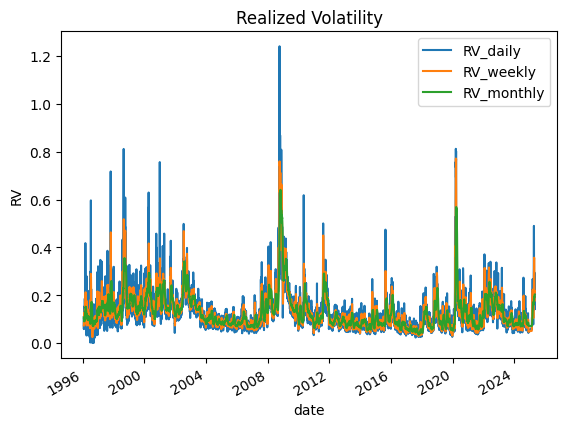

In [270]:
# Plot the RV variables
plt.figure(figsize=(12, 6))
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = "Realized Volatility")
plt.ylabel("RV")
plt.show()

#### 1.2. $\quad$ Prepare data for neural network models

For RNN and LSTM models, we need to create sequences of input data. We'll use a lookback window to predict the next day's volatility.

In [271]:
def create_sequences(data, lookback_days=30):
    """
    Create sequences for RNN/LSTM models.
    
    Args:
        data: DataFrame with RV features
        lookback_days: Number of days to look back for prediction
        
    Returns:
        X: Array of sequences (samples, timesteps, features)
        y: Array of targets
        dates: Corresponding dates for each sample
    """
    features = ['RV_daily', 'RV_weekly', 'RV_monthly']
    
    X, y, dates = [], [], []
    
    for i in range(lookback_days, len(data)):
        # Sequence of past lookback_days
        X.append(data[features].iloc[i-lookback_days:i].values)
        # Target is next day's daily RV
        y.append(data['RV_daily'].iloc[i])
        # Keep track of dates
        dates.append(data.index[i])
    
    return np.array(X), np.array(y), dates

# Create sequences
lookback_days = 22
X_seq, y_seq, seq_dates = create_sequences(rv, lookback_days)

print(f"Sequence data shape: X={X_seq.shape}, y={y_seq.shape}")
print(f"Features per timestep: {X_seq.shape[2]}")
print(f"Lookback window: {X_seq.shape[1]} days")

Sequence data shape: X=(7259, 22, 3), y=(7259,)
Features per timestep: 3
Lookback window: 22 days


In [272]:
# Split data into train/validation/test sets
train_size = int(0.6 * len(X_seq))
val_size = int(0.2 * len(X_seq))

X_train_seq = X_seq[:train_size]
X_val_seq = X_seq[train_size:train_size+val_size]
X_test_seq = X_seq[train_size+val_size:]

y_train_seq = y_seq[:train_size]
y_val_seq = y_seq[train_size:train_size+val_size]
y_test_seq = y_seq[train_size+val_size:]

train_dates = seq_dates[:train_size]
val_dates = seq_dates[train_size:train_size+val_size]
test_dates = seq_dates[train_size+val_size:]

print(f"Training samples: {len(X_train_seq)}")
print(f"Validation samples: {len(X_val_seq)}")
print(f"Test samples: {len(X_test_seq)}")

Training samples: 4355
Validation samples: 1451
Test samples: 1453


In [273]:
# Scale the features for better neural network performance
# Fit scaler on training data only
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape for scaling (flatten sequences)
X_train_reshaped = X_train_seq.reshape(-1, X_train_seq.shape[-1])
scaler_X.fit(X_train_reshaped)
scaler_y.fit(y_train_seq.reshape(-1, 1))

# Function to scale sequence data
def scale_sequences(X, y, scaler_X, scaler_y):
    X_scaled = np.zeros_like(X)
    for i in range(X.shape[0]):
        X_scaled[i] = scaler_X.transform(X[i])
    y_scaled = scaler_y.transform(y.reshape(-1, 1)).flatten()
    return X_scaled, y_scaled

# Scale all datasets
X_train_scaled, y_train_scaled = scale_sequences(X_train_seq, y_train_seq, scaler_X, scaler_y)
X_val_scaled, y_val_scaled = scale_sequences(X_val_seq, y_val_seq, scaler_X, scaler_y)
X_test_scaled, y_test_scaled = scale_sequences(X_test_seq, y_test_seq, scaler_X, scaler_y)

print("Data scaling completed.")

Data scaling completed.


### 2. $\quad$ Baseline: Traditional HAR-RV Model

First, let's establish a baseline with the traditional OLS HAR-RV model on the same test period.

In [274]:
# Prepare data for HAR model (using the same periods as neural networks)
rv_har = rv.iloc[lookback_days:].copy()  # Skip first lookback_days to align with neural network data
rv_har["Target"] = rv_har["RV_daily"].shift(-1)
rv_har.dropna(inplace=True)

# Add constant for OLS
rv_har_with_const = sm.add_constant(rv_har[['RV_daily', 'RV_weekly', 'RV_monthly']])

# Split using the same proportions
train_size_har = int(0.6 * len(rv_har))
val_size_har = int(0.2 * len(rv_har))

X_train_har = rv_har_with_const.iloc[:train_size_har]
X_test_har = rv_har_with_const.iloc[train_size_har+val_size_har:]
y_train_har = rv_har['Target'].iloc[:train_size_har]
y_test_har = rv_har['Target'].iloc[train_size_har+val_size_har:]

# Fit HAR model
har_model = sm.OLS(y_train_har, X_train_har).fit()
print("HAR-RV Model Summary:")
print(har_model.summary())

HAR-RV Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     3440.
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:54:53   Log-Likelihood:                 7020.9
No. Observations:                4354   AIC:                        -1.403e+04
Df Residuals:                    4350   BIC:                        -1.401e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.0

### 3. $\quad$ Simple RNN Model

Now let's implement a simple RNN model for volatility forecasting.

In [275]:
def build_rnn_model(input_shape, units=128, dropout=0.2):
    """
    Build a simple RNN model for volatility forecasting.
    
    Args:
        input_shape: Shape of input (timesteps, features)
        units: Number of RNN units
        dropout: Dropout rate
        
    Returns:
        Compiled Keras model
    """
    model = keras.Sequential([
        layers.SimpleRNN(units, return_sequences=True, input_shape=input_shape),
        # layers.Dropout(dropout),
        layers.SimpleRNN(units//2, return_sequences=False),
        # layers.Dropout(dropout),
        # layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')  # Sigmoid since we scaled targets to [0,1]
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Build RNN model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
rnn_model = build_rnn_model(input_shape)

print("RNN Model Architecture:")
rnn_model.summary()

RNN Model Architecture:


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_26 (SimpleRNN)       │ (None, 22, 128)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_27 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,313 (114.50 KB)

 Trainable params: 29,313 (114.50 KB)

 Non-trainable params: 0 (0.00 B)

In [276]:
# Train RNN model
print("Training RNN model...")

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Train the model
rnn_history = rnn_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=1000,
    batch_size=1024,
    callbacks=[early_stopping],
    verbose=1
)

print("RNN training completed.")

Training RNN model...
Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2902 - mae: 0.4770 - val_loss: 0.0133 - val_mae: 0.1050
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0219 - mae: 0.1261 - val_loss: 0.0148 - val_mae: 0.1098
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0163 - mae: 0.1102 - val_loss: 0.0058 - val_mae: 0.0606
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0102 - mae: 0.0858 - val_loss: 0.0041 - val_mae: 0.0444
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0070 - mae: 0.0577 - val_loss: 0.0072 - val_mae: 0.0695
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048 - mae: 0.0560 - val_loss: 0.0050 - val_mae: 0.0502
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037 - mae: 0.0419 - val_loss: 0.0048 - val_mae: 0.0492
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0032 - mae: 0.0399 - val_loss: 0.0048 - val_mae: 0.0485
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3

### 4. $\quad$ LSTM Model

Now let's implement an LSTM model, which should better capture long-term dependencies.

In [277]:
def build_lstm_model(input_shape, units=128, dropout=0.2):
    """
    Build an LSTM model for volatility forecasting.
    
    Args:
        input_shape: Shape of input (timesteps, features)
        units: Number of LSTM units
        dropout: Dropout rate
        
    Returns:
        Compiled Keras model
    """
    model = keras.Sequential([
        layers.LSTM(units, return_sequences=True, input_shape=input_shape),
        layers.LSTM(units//2, return_sequences=False),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse'
    )
    
    return model

# Build LSTM model
lstm_model = build_lstm_model(input_shape)

print("LSTM Model Architecture:")
lstm_model.summary()

LSTM Model Architecture:


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 22, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

In [278]:
# Train LSTM model
print("Training LSTM model...")

# Callbacks
early_stopping_lstm = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Train the model
lstm_history = lstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=1000,
    batch_size=1024,
    callbacks=[early_stopping_lstm],
    verbose=1
)

print("LSTM training completed.")

Training LSTM model...
Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0092 - val_loss: 0.0012
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0023 - val_loss: 7.9405e-04
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0023 - val_loss: 7.9442e-04
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0021 - val_loss: 9.1098e-04
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0021 - val_loss: 7.8673e-04
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0021 - val_loss: 7.5405e-04
Epoch 10/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0020 - val_loss: 7.8855e-04
Epoch 11/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0020 - val_loss: 7.5917e-04
Epoch 12/10

### 5. $\quad$ Model Evaluation and Comparison

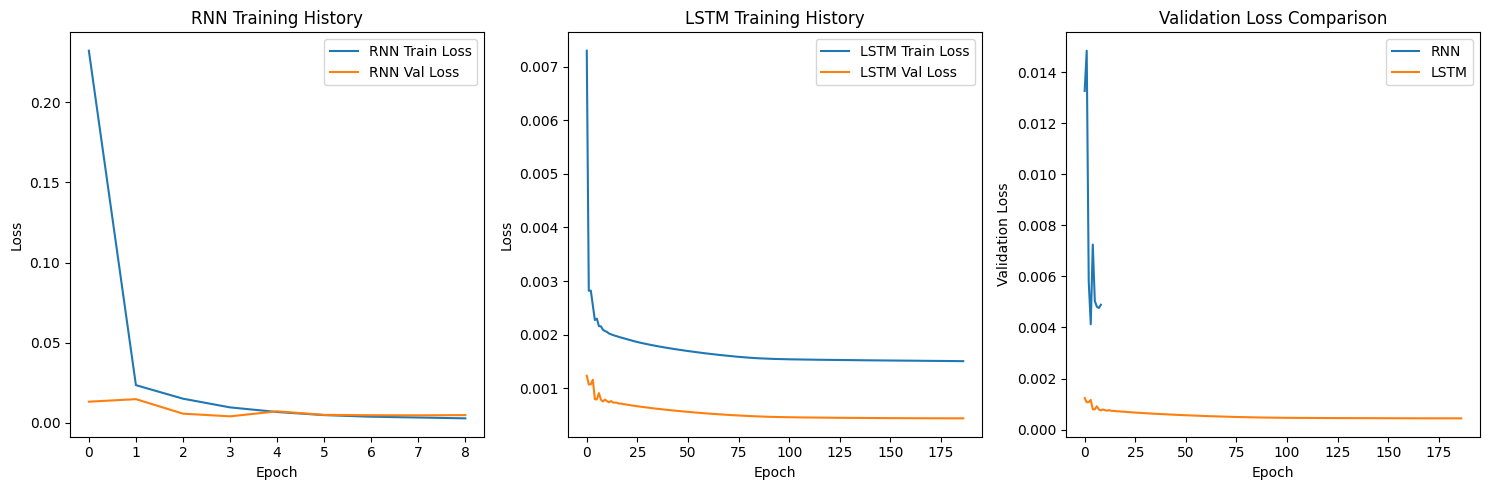

In [279]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.title('RNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(rnn_history.history['val_loss'], label='RNN')
plt.plot(lstm_history.history['val_loss'], label='LSTM')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [280]:
# Make predictions on test set
print("Making predictions...")

# HAR predictions
y_pred_har = har_model.predict(X_test_har)

# Neural network predictions (scaled)
y_pred_rnn_scaled = rnn_model.predict(X_test_scaled, verbose=0)
y_pred_lstm_scaled = lstm_model.predict(X_test_scaled, verbose=0)

# Inverse transform neural network predictions
y_pred_rnn = scaler_y.inverse_transform(y_pred_rnn_scaled.reshape(-1, 1)).flatten()
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
y_true = y_test_seq  # Original scale

print("Predictions completed.")

Making predictions...
Predictions completed.


In [281]:
# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Calculate metrics for all models
har_metrics = calculate_metrics(y_test_har.values, y_pred_har, "HAR-RV (OLS)")
rnn_metrics = calculate_metrics(y_true, y_pred_rnn, "RNN")
lstm_metrics = calculate_metrics(y_true, y_pred_lstm, "LSTM")

# Create comparison table
metrics_df = pd.DataFrame({
    'HAR-RV': har_metrics,
    'RNN': rnn_metrics,
    'LSTM': lstm_metrics
})

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(metrics_df.round(6))


HAR-RV (OLS) Performance:
MSE: 0.001583
RMSE: 0.039782
MAE: 0.026306
R²: 0.7736

RNN Performance:
MSE: 0.007260
RMSE: 0.085207
MAE: 0.055766
R²: -0.0385

LSTM Performance:
MSE: 0.001572
RMSE: 0.039643
MAE: 0.026473
R²: 0.7752

MODEL COMPARISON
        HAR-RV       RNN      LSTM
MSE   0.001583  0.007260  0.001572
RMSE  0.039782  0.085207  0.039643
MAE   0.026306  0.055766  0.026473
R2    0.773620 -0.038539  0.775193


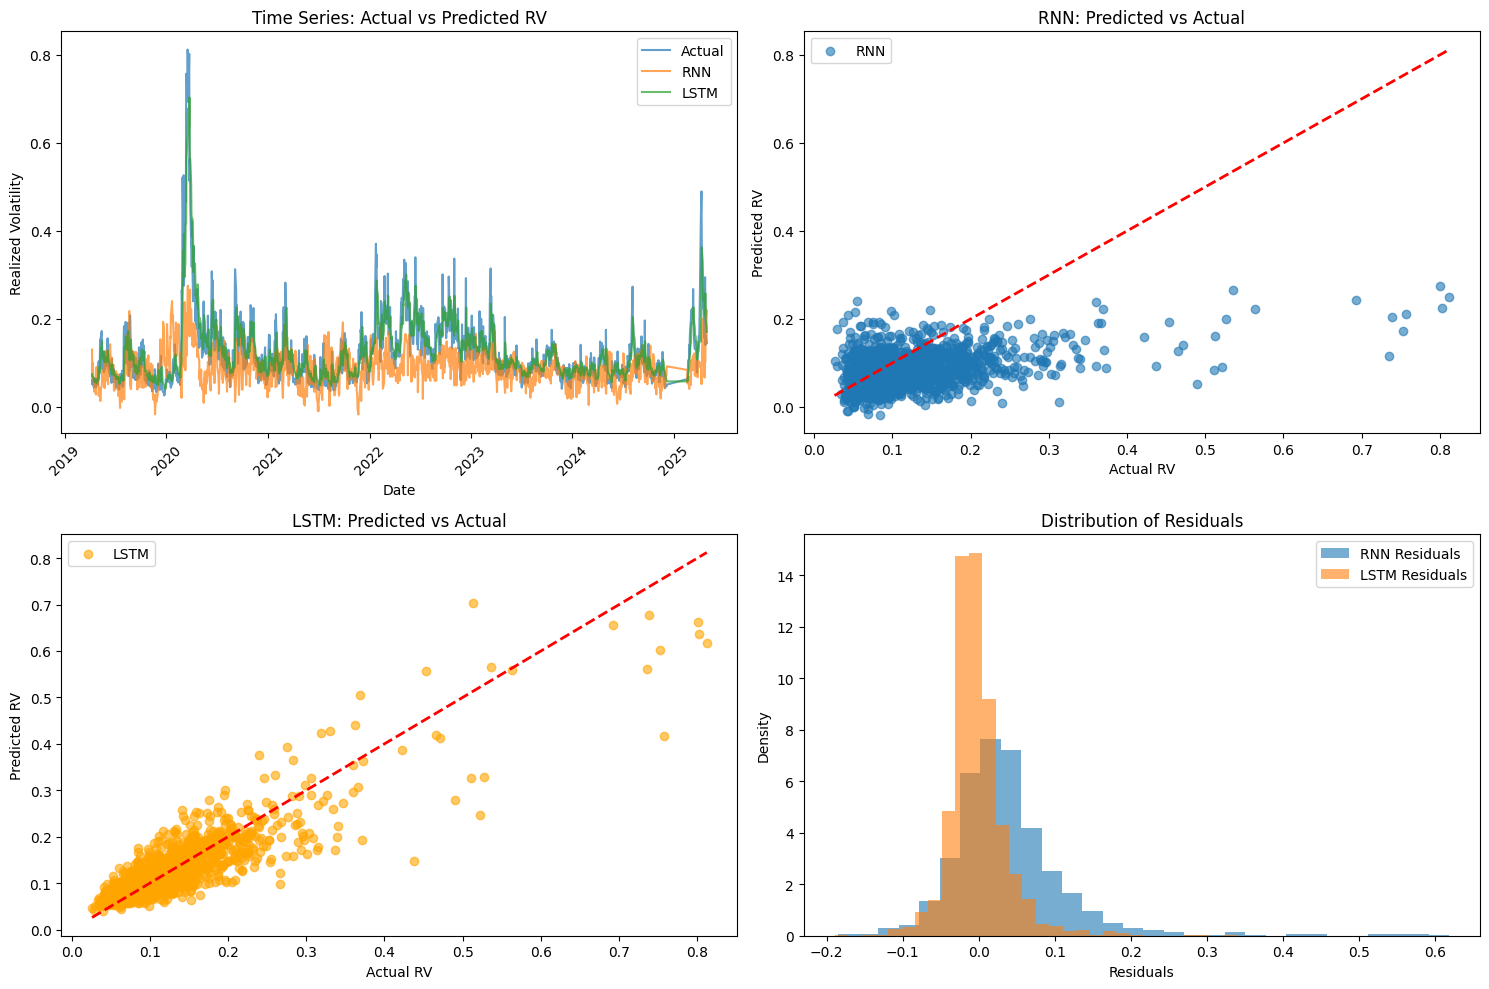

In [282]:
# Plot predictions vs actual values
plt.figure(figsize=(15, 10))

# Time series plot
plt.subplot(2, 2, 1)
test_dates_pd = pd.to_datetime(test_dates)
plt.plot(test_dates_pd, y_true, label='Actual', alpha=0.7)
plt.plot(test_dates_pd, y_pred_rnn, label='RNN', alpha=0.7)
plt.plot(test_dates_pd, y_pred_lstm, label='LSTM', alpha=0.7)
plt.title('Time Series: Actual vs Predicted RV')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.legend()
plt.xticks(rotation=45)

# Scatter plots
plt.subplot(2, 2, 2)
plt.scatter(y_true, y_pred_rnn, alpha=0.6, label='RNN')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual RV')
plt.ylabel('Predicted RV')
plt.title('RNN: Predicted vs Actual')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(y_true, y_pred_lstm, alpha=0.6, label='LSTM', color='orange')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual RV')
plt.ylabel('Predicted RV')
plt.title('LSTM: Predicted vs Actual')
plt.legend()

# Residual analysis
plt.subplot(2, 2, 4)
rnn_residuals = y_true - y_pred_rnn
lstm_residuals = y_true - y_pred_lstm
plt.hist(rnn_residuals, bins=30, alpha=0.6, label='RNN Residuals', density=True)
plt.hist(lstm_residuals, bins=30, alpha=0.6, label='LSTM Residuals', density=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.legend()

plt.tight_layout()
plt.show()

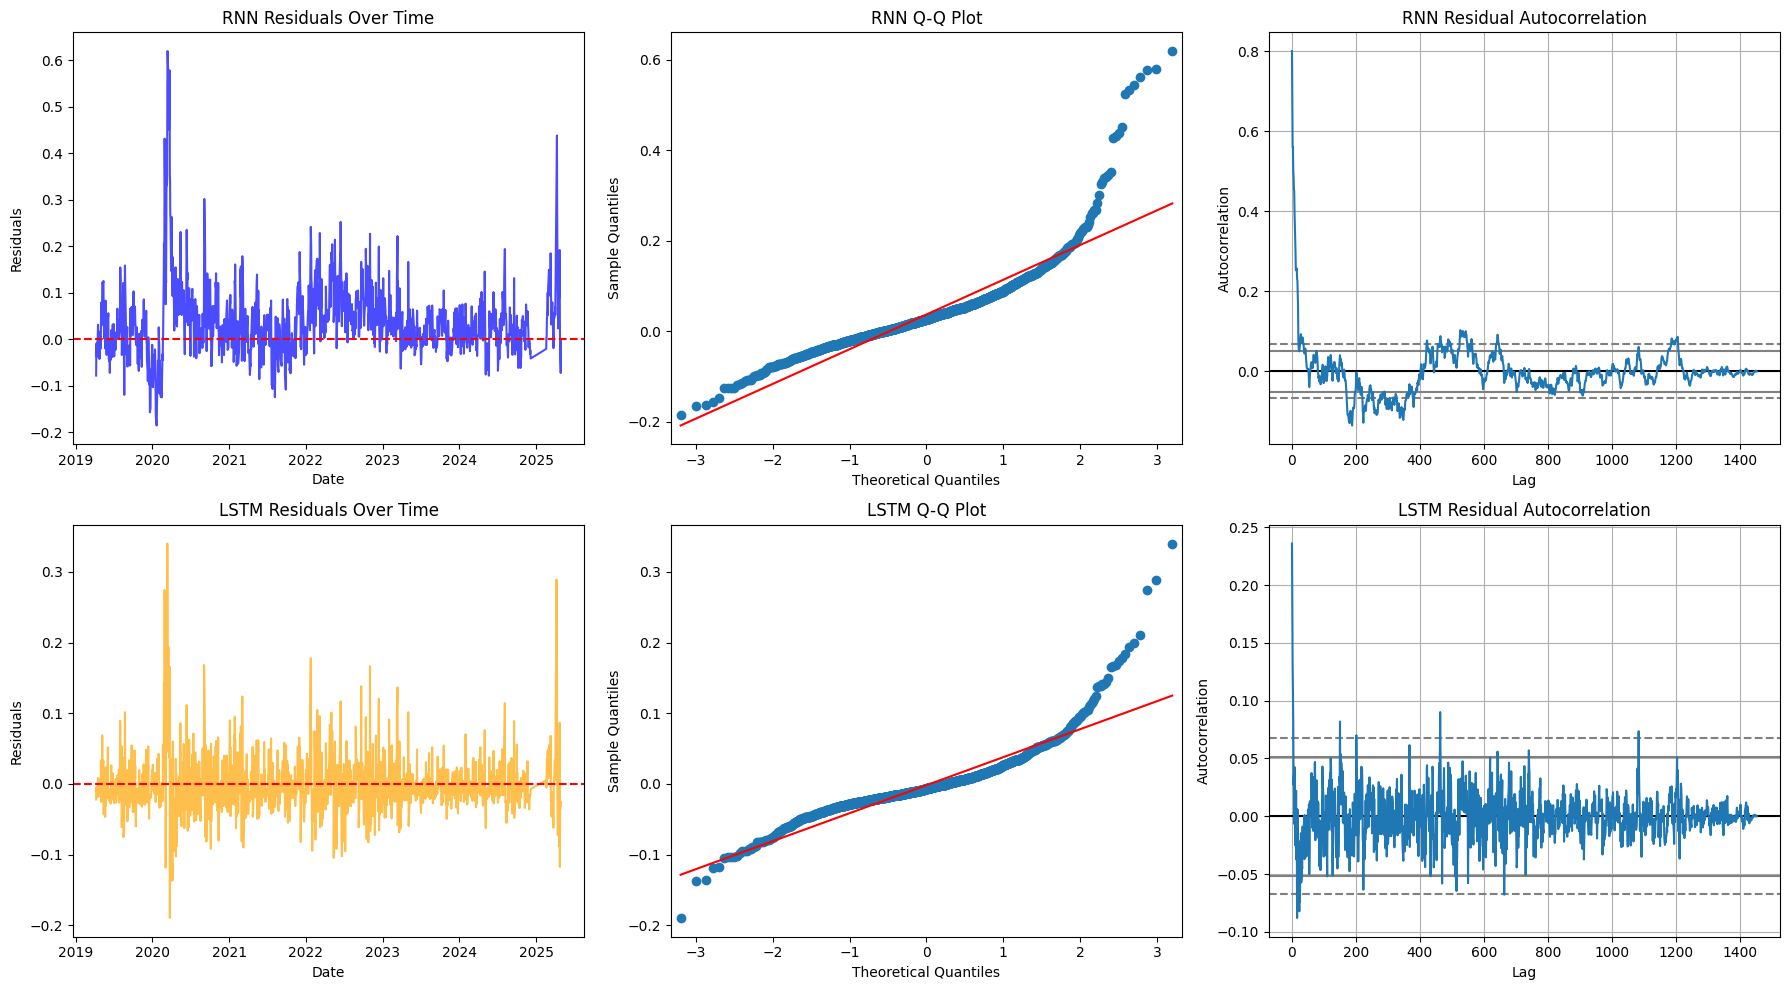

In [283]:
# Additional analysis: Residual diagnostics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = ['RNN', 'LSTM']
residuals = [rnn_residuals, lstm_residuals]
colors = ['blue', 'orange']

for i, (model, resid, color) in enumerate(zip(models, residuals, colors)):
    # Residuals over time
    axes[i, 0].plot(test_dates_pd, resid, color=color, alpha=0.7)
    axes[i, 0].axhline(y=0, color='red', linestyle='--')
    axes[i, 0].set_title(f'{model} Residuals Over Time')
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('Residuals')
    
    # Q-Q plot
    qqplot(resid, ax=axes[i, 1], line='s')
    axes[i, 1].set_title(f'{model} Q-Q Plot')
    
    # Autocorrelation of residuals
    autocorrelation_plot(resid, ax=axes[i, 2])
    axes[i, 2].set_title(f'{model} Residual Autocorrelation')
    axes[i, 2].set_xlabel('Lag')

plt.tight_layout()
plt.show()

In [284]:
# Summary statistics
print("\nSUMMARY STATISTICS")
print("="*50)

print(f"\nTest period: {test_dates[0]} to {test_dates[-1]}")
print(f"Number of test observations: {len(y_true)}")

print(f"\nActual RV statistics:")
print(f"Mean: {np.mean(y_true):.6f}")
print(f"Std: {np.std(y_true):.6f}")
print(f"Min: {np.min(y_true):.6f}")
print(f"Max: {np.max(y_true):.6f}")

print(f"\nBest performing model by R²: ", end="")
best_model = max(metrics_df.columns, key=lambda x: metrics_df.loc['R2', x])
print(f"{best_model} (R² = {metrics_df.loc['R2', best_model]:.4f})")

print(f"\nBest performing model by RMSE: ", end="")
best_rmse_model = min(metrics_df.columns, key=lambda x: metrics_df.loc['RMSE', x])
print(f"{best_rmse_model} (RMSE = {metrics_df.loc['RMSE', best_rmse_model]:.6f})")


SUMMARY STATISTICS

Test period: 2019-04-08 00:00:00 to 2025-04-29 00:00:00
Number of test observations: 1453

Actual RV statistics:
Mean: 0.123707
Std: 0.083611
Min: 0.026052
Max: 0.812061

Best performing model by R²: LSTM (R² = 0.7752)

Best performing model by RMSE: LSTM (RMSE = 0.039643)
